# Classification Trees

## Introduction

>A classification tree is a type of **decision tree** that is used for predicting categorical outputs. In the next notebook, we will explore regression trees, which are used for making continuous predictions.

If you have ever played the game 21 questions, you have an idea of what a classification tree is. In the coding context, if you have ever attempted to code an artificial general intelligence using many `if` statements, you have essentially built a decision tree by hand.

These examples employ the conventional approach to building a classifier, which involves asking a series of yes/no questions.
The answer to each question provides more information on the class of the object until the range of possible options becomes fine enough for the user to settle on a prediction.

Below is an example of such a classifier. This one predicts the sex using the height and weight of a person.

![](images/CARTS_example_tree.png)

The above examples, however, are dependent on the user finding the right questions manually. Our goal is to be able to find the right questions automatically using ML. This suggests that we need to begin quantifying what makes a **good** split.

![](images/CARTS_geni_impurity.png)

![](images/CARTS_split_pos.png)

## Maximum Depth
The maximum depth is an important hyperparameter for our tree.

Once the tree has been fitted to our data, it will make classifications by evaluating which leaf of the tree a given input arrives at. Thereafter, it classifies it as a member of the mode (most common) class of all the other points in the dataset, which are also at that leaf.

Let us build a classification tree from scratch. The first cell below sets up some helper functions that we used previously.

In [2]:
# Run this cell to download the necessary package to run the next cell
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/get_colors.py" "https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/utils.py"

--2021-10-26 16:09:24--  https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/get_colors.py
Resolviendo aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)... 52.217.168.137
Conectando con aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)[52.217.168.137]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 256 [text/x-python-script]
Grabando a: «get_colors.py.1»

get_colors.py.1     100%[===================>]     256  --.-KB/s    en 0s      

2021-10-26 16:09:25 (5.09 MB/s) - «get_colors.py.1» guardado [256/256]

--2021-10-26 16:09:25--  https://aicore-files.s3.amazonaws.com/Data-Science/data_utils/utils.py
Reutilizando la conexión con aicore-files.s3.amazonaws.com:443.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 2733 (2.7K) [text/x-python-script]
Grabando a: «utils.py»

utils.py            100%[===================>]   2.67K  --.-KB/s    en 0.001s  

2021-10-26 16:09:25 (3.08 MB/s) - «utils.py» guardado [2733

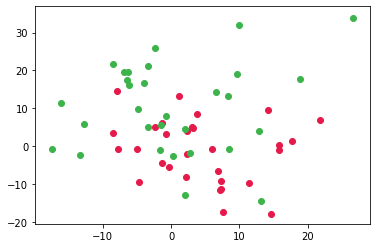

In [6]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import sklearn.datasets
from utils import get_classification_data, show_data, visualise_predictions, colors

m = 60
n_features = 2
n_classes = 2
X, Y = get_classification_data(sd=10, m=60, n_clusters=n_classes, n_features=n_features)
show_data(X, Y)

                                                        "classification": 0.0
                                                            },
                                                            "negative_branch": {
                                                                "split_impurity": 0,
                                                                "classification": 1.0
                                                            }
                                                        },
                                                        "negative_branch": {
                                                            "split_impurity": 0.0,
                                                            "feature_to_split_on": 0,
                                                            "value_to_split_on": -1.4449889905837692,
                                                            "positive_branch": {
                                                         

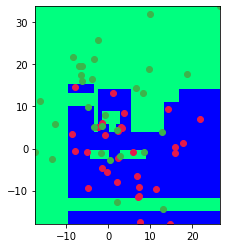

In [8]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
import json
import copy

class ClassificationTree:
    def __init__(self, max_depth=4):
        self.max_depth = max_depth

    def get_region_impurity(self, examples_in_region):
        """Get the impurity of a region"""
        x, Y = examples_in_region # unpack features and labels
        n_classes = np.ptp(Y) # get the number of label classes from the range of integer labels 
        n_datapoints = len(x) # get the number of datapoints
        impurity = 0 # initialise zero impurity for this region
        for class_idx in range(n_classes): # for each class
            n_examples_in_class = len(x[Y == class_idx]) # get the number of examples in this class
            p_k = n_examples_in_class / n_datapoints # compute the proportion of examples in this region in class k
            impurity += p_k * (1 - p_k) # compute impurity from the proportion
        return impurity # return the impurity

    def get_split_impurity(self, x, Y, split_pos):
        """Get the impurity of a split by making a weighted combination of its resulting region impurities"""
        in_first_region = (x[x > split_pos], Y[x > split_pos]) # get the number of examples in the first region
        proportion_in_first_region = len(in_first_region) / len(x) # calculate proportion of examples in first region
        not_in_first_region = (x[x <= split_pos], Y[x <= split_pos]) # get the number of examples in the other region
        proportion_not_in_first_region = 1 - proportion_in_first_region # calculate the proportion of examples in the other region
        impurity = 0 # initialise impurity of split as zero
        impurity += proportion_in_first_region * self.get_region_impurity(in_first_region) # add the impurity of the first region, weighted by the proportion of examples that this split separates, which end up in that region
        impurity += proportion_not_in_first_region * self.get_region_impurity(not_in_first_region) # add the impurity of the other region, weighted by the proportion of examples that this split separates, which end up in that region
        return impurity # return the total impurity

    def get_split_candidates(self, x):
        """Take in an array of a particular feature for each example, and return an array of feature values at which to consider splitting the data along this feature axis"""
        return (x[:-1] + x[1:]) / 2

    def get_best_split(self, X, Y):
        """Consider the features and labels of all of the datapoints. Compute the best value and feature dimensions on which to split the data. Return the best feature value and feature index, as well as the impurity of the split""" 
        best_feature_to_split_on = None # initialise the best feature to split on as none
        best_impurity = float('inf') # initialise best impurity found as infinity
        best_split_pos = None # initialise the best value to split the data on as none
        for feature_idx in range(n_features): # for each feature
            x = X[:, feature_idx] # get this feature from each example
            split_pos, split_impurity = self.get_best_split_on_this_feature(x, Y) # get the best split position along this feature axis
            # print('feature impurity:', split_impurity)
            if split_impurity < best_impurity: # if this split impurity is the best so far,
                best_split_pos = split_pos # update the best split position to this one
                best_impurity = split_impurity # update the best split impurity to this one
                best_feature_to_split_on = feature_idx # update the best split feature to this one
        # print('best_split_impurity:', best_impurity)
        return best_split_pos, best_impurity, best_feature_to_split_on # return the best split position, impurity and feature idx

    def get_best_split_on_this_feature(self, x, Y):
        """
        Take in an array of a particular feature for each example and an array of their labels.
        Return the best value to split the data along this feature.
        """
        split_candidates = self.get_split_candidates(x) # get candidate feature values to split the data on
        best_impurity = float('inf') # initialise the best impurity as infinity
        best_split_pos = None # initialise the best position to split on as none
        for split_pos in split_candidates: # for each candidate split position
            impurity = self.get_split_impurity(x, Y, split_pos) # get the split impurity
            if impurity < best_impurity: # if this is the best impurity so far,
                best_impurity = impurity # update the best impurity to this one
                best_split_pos = split_pos # update the best split position to this one
        return best_split_pos, best_impurity # return the best split position and best impurity

    def extend_tree(self, X, Y, depth=0):
        """
        Recursively grow the tree
        """
        split_val, split_impurity, split_feature = self.get_best_split(X, Y) # get the best split position
        if split_val == None: # split val will not exist (None) if there is only one datapoint in the split
            new_branch = {
                'split_impurity': 0, # so the split is pure
                'classification': np.mean(Y)
            }
            return new_branch
        
        positive_idxs = X[:, split_feature] > split_val # get the idxs of the datapoints that are split into the first region
        positive_X = X[positive_idxs] # get their features 
        positive_Y = Y[positive_idxs] # get their labels
        negative_idxs = np.logical_not(positive_idxs) # get the idxs of the datapoints that are split into the other region
        negative_X = X[negative_idxs] # get their features
        negative_Y = Y[negative_idxs] # get their labels
        new_branch = { # branch to be added to the tree
            'split_impurity': split_impurity, # the split impurity of this branch
        }

        if depth < self.max_depth: # if not yet at max depth
            new_branch.update({ # add other attributes to the branch
                'feature_to_split_on': split_feature,
                'value_to_split_on': split_val,
                'positive_branch': self.extend_tree(positive_X, positive_Y, depth=depth+1), # recursion call 
                'negative_branch': self.extend_tree(negative_X, negative_Y, depth=depth+1) # reursion call
            })
        else: # if at max depth, stop growing the tree
            new_branch.update({'classification': np.mean(Y)}) # and simply classify the examples here as the mean
        return new_branch

    def fit(self, X, Y):
        """Grows the tree"""
        self.tree = self.extend_tree(X, Y) # recursive function to grow the tree

    def predict(self, X):
        """Makes predictions using the fitted tree"""
        classifications = np.zeros(len(X)) # initialise an empty list of predictions
        for idx, x in enumerate(X): # enumerate over each example
            classified = False # indicator of whether it has been classified yet (initially false)
            tree = self.tree # prevents unnecessary repetition

            while classified == False: # while not yet classified
                if 'classification' in tree.keys(): # if the example can be classified from this branch (we have reached a leaf),
                    classified = True # mark as classified
                    classifications[idx] = tree['classification'] # get classification from this leaf of the tree
                else: # if we need to ask further questions about the example to make splits,
                    if x[tree['feature_to_split_on']] > tree['value_to_split_on']: # is the example in the positive branch,
                        tree = tree['positive_branch'] # move down this branch of the tree and continue the loop
                    else: # if the example is in the negative branch of the tree,
                        tree = tree['negative_branch'] # move down this branch of the tree and continue the loop

        return classifications # return the list of classifications

    def __repr__(self):
        """Returns a string representation of the tree"""
        return json.dumps(self.tree, indent=4) # convert the json representation of the tree into a string with a nice indentation for readability

classificationTree = ClassificationTree(max_depth=50)
classificationTree.fit(X, Y)
visualise_predictions(classificationTree.predict, X, Y)
print(classificationTree)


Now, we will use sklearn for the implementation. 

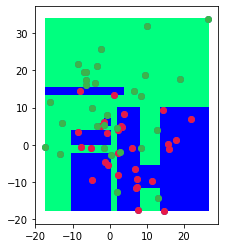

In [10]:
import sklearn.tree

classificationTree = sklearn.tree.DecisionTreeClassifier(max_depth=50)

classificationTree.fit(X, Y)
classificationTree.predict(X)
visualise_predictions(classificationTree.predict, X)
show_data(X, Y)


## sklearn Hyperparameters

[Here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is the full documentation for the sklearn classification tree.

## Classification Tree Limitations
- It is very prone to overfitting: no generalisation between similar examples.
- Every midpoint between each consecutive example must be considered as a position to split the data every time the tree is grown: the larger the dataset, the more time is required for the fitting.
- The candidate positions to split the data must be considered along each feature axis.

## Conclusion
At this point, you should have a good understanding of

- decision trees and their importance.
- how to split data optimally.
- Geni impurity and how to evaluate it.